# Run necessary set-up.
install the ONE API, IBL library, and several other libraries/toolkits we will use to access and analyze our data.

In [ ]:
! pip install ONE-api
! pip install ibllib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 1.7 MB/s 
     |████████████████████████████████| 57 kB 3.0 MB/s 
     |████████████████████████████████| 132 kB 46.5 MB/s 
     |████████████████████████████████| 41 kB 59 kB/s 
     |████████████████████████████████| 62 kB 697 kB/s 
     |████████████████████████████████| 79 kB 5.8 MB/s 
     |████████████████████████████████| 10.3 MB 100 kB/s 
     |████████████████████████████████| 127 kB 20.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.6 MB 7.4 MB/s 
     |████████████████████████████████| 47 kB 5.8 MB/s 
     |████████████████████████████████| 93 kB 2.7 MB/s 
     |███████████████

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from brainbox.io.one import SpikeSortingLoader
from brainbox.plot import peri_event_time_histogram
from brainbox.singlecell import calculate_peths

from ibllib.atlas import AllenAtlas
from one.api import ONE

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Lasso
from sklearn.model_selection import KFold
one = ONE(base_url='https://openalyx.internationalbrainlab.org', password='international', silent=True)
ba = AllenAtlas()

Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/histology/ATLAS/Needles/Allen/average_template_25.nrrd Bytes: 32998960


100%|██████████| 31.470260620117188/31.470260620117188 [00:03<00:00,  9.72it/s]


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/histology/ATLAS/Needles/Allen/annotation_25.nrrd Bytes: 4035363


100%|██████████| 3.848422050476074/3.848422050476074 [00:01<00:00,  2.38it/s]


# Load data
Pull in the data from the IBL using the ONE API, format for useability in future analysis. 

In [ ]:
from IPython.terminal.interactiveshell import TerminalInteractiveShell
from brainbox.population import decode
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from scipy import stats

insertions = one.alyx.rest('insertions', 'list', django='datasets__tags__name,2022_Q4_IBL_et_al_BWM')
pids = [i['id'] for i in insertions]
print(f'Found {len(insertions)} insertions')
# Load in the neural data of the first insertion
sl = SpikeSortingLoader(pid=pids[0], one=one, atlas=ba)
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)

# Load in the trials
trials = one.load_object(one.pid2eid(pids[0])[0], 'trials')



Found 547 insertions


/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0027/2022-08-23/001/alf/probe00/pykilosort/spikes.amps.npy: 100%|██████████| 50.6M/50.6M [00:01<00:00, 34.5MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0027/2022-08-23/001/alf/probe00/pykilosort/spikes.clusters.npy: 100%|██████████| 25.3M/25.3M [00:00<00:00, 48.6MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0027/2022-08-23/001/alf/probe00/pykilosort/spikes.depths.npy: 100%|██████████| 50.6M/50.6M [00:00<00:00, 67.4MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0027/2022-08-23/001/alf/probe00/pykilosort/spikes.times.npy: 100%|██████████| 50.6M/50.6M [00:00<00:00, 82.4MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0027/2022-08-23/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.9kB/s]
/root

## Why we chose this particular data set

We wanted to look at neural (spiking) data to see if there was any predictive power of internal (non-external) factors for mice choice. We thus chose the brain-wide map data set because, if our result showed significant predictive power of pre-stimulus spiking, we would want to explore which brain regions were most predictive.


## Which and how many sessions were sampled

In our final analysis, we sampled from one in every ten sessions totaling 54 sessions. We chose not to look at all sessions due to computational limits, but we believe that this is a sufficient number of sessions to look at. Apart from the cross-session analysis which we did at the end, we chose to use the first session for all the models. 


# Attempt 1: Trying to Predict Correctness of Choice

Our first attempt sought to model the mouse's accuracy with it's spiking data in a pre-stimulus interval. We applied logistic regression to spiking data against correctness of choice, using input boxes to seek out optimal hyperparameters (some of the best are hardcoded here for demonstration purposes)

splits for kfold? 5
predictions must exceed 82.14689265536722 % to be significant
maxium score: 82.14689265536722 % with  5.0 folds and  0.01 second time interval


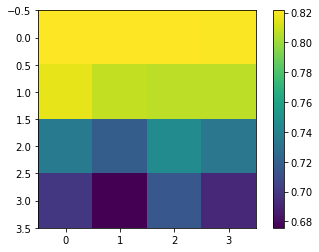

In [ ]:
from scipy import stats
#reg_levels= (np.array((input('reg_level? ')).split(','), )).astype(float)
#time_int= (np.array((input('time interval(s)? ')).split(','), )).astype(float)
choice_acc = trials['feedbackType']
print("predictions must exceed",(np.mean((choice_acc +1)/2))*100,"% to be significant")

reg_levels= [0.001,0.01,0.1,1]
time_int= [0.01,0.05,0.1,0.2]

log_scores = np.zeros((len(reg_levels), len(time_int)))
for reg in range(len(reg_levels)):
  for t in range(len(time_int)):
    intervals_previous = np.vstack((trials['stimOn_times'] - time_int[t], trials['stimOn_times']- time_int[t]/10)).T
    spike, _ = decode.get_spike_counts_in_bins(spikes['times'], spikes['clusters'], intervals=intervals_previous)
    spike=stats.zscore(spike, axis = 1)
    spike= np.nan_to_num(spike,copy=False)
    cross_validation= KFold(n_splits = 5)
    classifier= LogisticRegression(max_iter=1e4, C=reg_levels[reg])
    acc_acc, pred_acc, prob_acc= decode.classify(spike.T,
                                  choice_acc, 
                                  classifier,
                                  cross_validation=cross_validation)
    log_scores[reg, t]+= (acc_acc)

plt.imshow(log_scores)
plt.colorbar()
max_score = np.amax(log_scores)
max_score_at = np.unravel_index(np.argmax(log_scores, axis=None), log_scores.shape)
print("maxium score:", max_score*100,"% with ", splits[max_score_at[0]], "folds and ", time_int[max_score_at[1]], "second time interval")

Since our results were insignificant, we examined something that was highly likely to predict a mouse's accuracy (its past choice) to try and predict the accuracy of its current choice. We created a design matrix of it's accuracy and compared it against the original accuracy vector.

In [ ]:
from scipy.linalg import toeplitz #function for making a time-lag design matrix

def make_design(source,d): #create a function that takes a matrix and outputs design matrix
  if source.ndim == 1: 
    source = np.expand_dims(source,1)
  source_toep = np.zeros((source.shape[0], d*source.shape[1])) 
  for i in range(source.shape[1]): 
    source_toep[1:,d* i: d* (i+1)] = toeplitz(source[:-1,i], np.zeros(d))  
  return source_toep


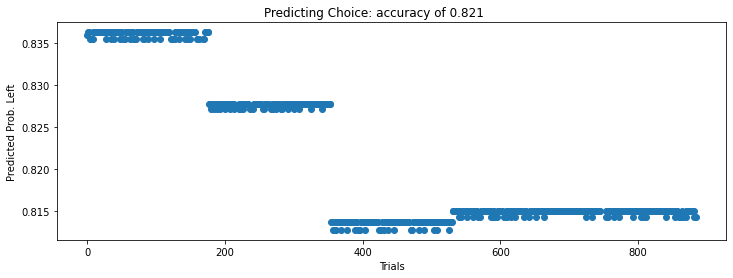

In [ ]:
choice_design = make_design(choice_acc, d=1)
cross_validation = KFold(n_splits = 5)
classifier = LogisticRegression(max_iter=1e4, C=0.0001)
acc2, pred2, prob2 = decode.classify(choice_design,
                                  choice_acc, 
                                  classifier,
                                  cross_validation=cross_validation)


plt.figure(figsize=(12,4))
plt.title(f'Predicting Choice: accuracy of {acc2:.3f}         ')
trialnumber = np.arange(len(contrast_all))
plt.plot(trialnumber[choice_acc==1], prob2[choice_acc==1], 'o')
plt.plot(trialnumber[choice_acc==0], prob2[choice_acc==0], 'o')
plt.ylabel('Predicted Prob. Left')
plt.xlabel('Trials')
plt.show()

Our best predictive accuracy did not surpass the threshold of chance, or perform better than a model trained on just the previous choice. So we tried regressing against the side of choice instead.



# Attempt 2: Trying to predict side of choice (Main Model)

### Model Details

The main model looks at the impact of pre-stimulus spiking on the choice of side that mice make (here, we have arbitrarily chosen whether the mouse chooses left, but conceptually this doesn’t matter for a binary decision). Thus, the dependent variable is the choice of side for each trial and the independent variable is the number of spikes before the stimulus is shown for each trial. Our aim is to evaluate whether the choice of side the mouse makes can be predicted by the spiking before the stimulus is shown.

The null model is chance-level accuracy, which can be calculated by the percentage of trials where the mouse chooses left. Intuitively, if we know which side the mouse chooses more often (here, left), and specified a model that chose left every time, it would do exactly as well as how often the mouse chose left. For the first session, chance is 62.4%, thus any accuracy lower or the same as this chance means the model does not surpass the threshold of chance.



1. Data standardization (e.g. z-scoring)  
2.	Time intervals and/or binning  
3.	Regularization strength  
4.	Cross-validation

### Choice Side Regression

Load spikes, create the contrast variable with a direction. Establish basic threshold of chance

In [ ]:
intervals_previous = np.vstack((trials['stimOn_times'] - 0.05, trials['stimOn_times']- 0.05/10)).T
spike, _ = decode.get_spike_counts_in_bins(spikes['times'], spikes['clusters'], intervals=intervals_previous)
spike=stats.zscore(spike, axis = 1)
spike= np.nan_to_num(spike,copy=False)
spike = spike.T
choice_side = np.asarray((trials['choice']+1)/2,dtype=int)

print("prediction must exceed", np.mean(choice_side)*100,"% test accuracy to be significant")

prediction must exceed 62.37288135593221 % test accuracy to be significant


Run regression on spikes 

maxium score: 62.485875706214685 % with  0.0005 regularization and  0.1 second time interval


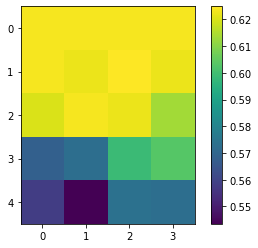

In [ ]:
#reg_level= (np.array((input('regularization? ')).split(','), )).astype(float)
#time_int= (np.array((input('time interval(s)? ')).split(','), )).astype(float)
choice_side = np.asarray((trials['choice']+1)/2,dtype=int)
reg_level= [0.0001, 0.0005, 0.001,0.01,0.1]
time_int= [0.01,0.05,0.1,0.2]

log_scores = np.zeros((len(reg_level), len(time_int)))
for reg in range(len(reg_level)):
  for t in range(len(time_int)):
    intervals_previous = np.vstack((trials['stimOn_times'] - time_int[t], trials['stimOn_times']- time_int[t]/10)).T
    spike, _ = decode.get_spike_counts_in_bins(spikes['times'], spikes['clusters'], intervals=intervals_previous)
    spike=stats.zscore(spike, axis = 1)
    spike= np.nan_to_num(spike,copy=False)
    cross_validation= KFold(n_splits = 5)
    classifier= LogisticRegression(max_iter=1e4, C= reg_level[reg])
    acc_choice, pred_choice, prob_choice= decode.classify(spike.T,
                                  choice_side, 
                                  classifier,
                                  cross_validation=cross_validation)
    log_scores[reg, t]= (acc_choice)
    
plt.imshow(log_scores)
plt.colorbar()
max_score = np.amax(log_scores)
max_score_at = np.unravel_index(np.argmax(log_scores, axis=None), log_scores.shape)
print("maxium score:", max_score*100,"% with ", reg_level[max_score_at[0]], "regularization and ", time_int[max_score_at[1]], "second time interval")

We regress with spikes using found hyperparameters to view prediction probabilities at those levels. We find that the highest accuracy came with 0.0005 regularization and  0.1 second time interval, thus, we used this for all regressions using spiking data.

Additionally, we included z-scoring, as it allows us to focus more on the differences between the data points instead of their distance from zero. This allows us to normalize the data, and describe relationships of spiking data relative to the mean rather than to zero.

Finally, we chose 5 folds for cross-validation as more folds allows us to arrive at better estimates with less bias, but there are computational costs related to greater folds.


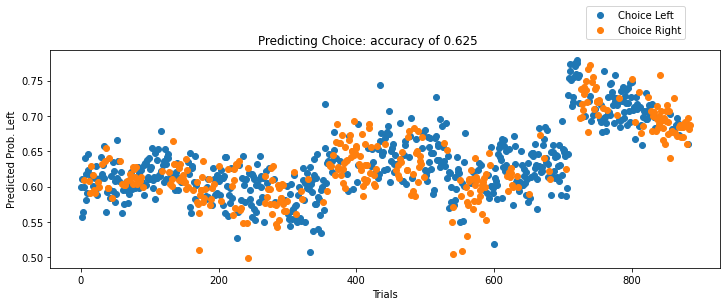

In [ ]:
choice_side = np.asarray((trials['choice']+1)/2,dtype=int)
intervals_previous = np.vstack((trials['stimOn_times'] - 0.1, trials['stimOn_times']- 0.05/10)).T
spike, _ = decode.get_spike_counts_in_bins(spikes['times'], spikes['clusters'], intervals=intervals_previous)
spike=stats.zscore(spike, axis = 1)
spike= np.nan_to_num(spike,copy=False)

cross_validation = KFold(n_splits=5)
classifier = LogisticRegression(max_iter=1e4, C=0.0005)
acc2, pred2, prob2 = decode.classify(spike.T,
                                  choice_side, 
                                  classifier,
                                  cross_validation=cross_validation)

plt.figure(figsize=(12,4))
plt.title(f'Predicting Choice: accuracy of {acc2:.3f}         ')
trialnumber = np.arange(len(choice_side))
plt.plot(trialnumber[choice_side==1], prob2[choice_side==1], 'o')
plt.plot(trialnumber[choice_side==0], prob2[choice_side==0], 'o')
plt.legend(['Choice Left', 'Choice Right'], loc=(0.8,1.05))
plt.ylabel('Predicted Prob. Left')
plt.xlabel('Trials')
plt.show()

With an accuracy of 62.4%, the regression shows us that the pre-stimulus spiking data has no predictive power in what side the mouse chooses, because this is identical to the chance-level accuracy for this particular session it does not surpass the threshold of chance. The plot indicates that the accuracy is generally constant across all trials, although there is a slight increase in accuracy in the last 100 trials.


# Checks and Controls

Next, we ran a series of checks to ensure that our framework was working despite the insignificant results. Firstly, we ran a regression replacing pre-stimulus spiking with post-stimulus spiking. Secondly, we examined the predictive power of the level and direction of contrast on the choice made. Thirdly, we created a model using previous trial choice to predict the choice of the mouse. Lastly, we explored whether pre-stimulus spiking had predictive power on previous trial choice.  


## Positive Controls


Regress with spikes after stimulus presentation to confirm the efficacy of our regression and spike data

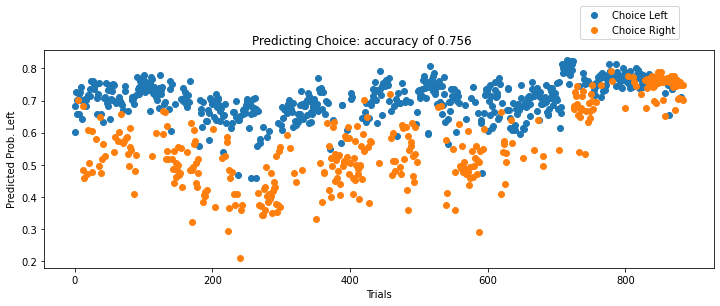

In [ ]:
choice_side = np.asarray((trials['choice']+1)/2,dtype=int)
intervals_previous = np.vstack((trials['stimOn_times'], trials['stimOn_times']+0.4)).T
spike, _ = decode.get_spike_counts_in_bins(spikes['times'], spikes['clusters'], intervals=intervals_previous)
spike=stats.zscore(spike, axis = 1)
spike= np.nan_to_num(spike,copy=False)

cross_validation = KFold(n_splits=5)
acc2, pred2, prob2 = decode.classify(spike.T,
                                  choice_side, 
                                  classifier,
                                  cross_validation=cross_validation)

plt.figure(figsize=(12,4))
plt.title(f'Predicting Choice: accuracy of {acc2:.3f}         ')
trialnumber = np.arange(len(choice_side))
plt.plot(trialnumber[choice_side==1], prob2[choice_side==1], 'o')
plt.plot(trialnumber[choice_side==0], prob2[choice_side==0], 'o')
plt.legend(['Choice Left', 'Choice Right'], loc=(0.8,1.05))
plt.ylabel('Predicted Prob. Left')
plt.xlabel('Trials')
plt.show()

To confirm that our framework is working, post-stimulus spiking should be a strong predictor of the mouse’s choice of side–this should definitely be higher than chance. We find that the accuracy of this mode is 75.6% providing a positive control, pointing to the fact that our framework is valid. 


### Contrast Only Model

In [ ]:
contrast_all = trials['contrastLeft']
contrast_right = trials['contrastRight']
contrast_all[np.isnan(contrast_all)] = -contrast_right[np.isnan(contrast_all)]
spike_contrast = np.vstack((spike,contrast_all))

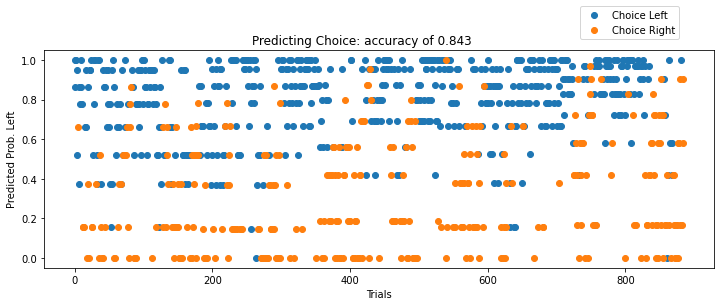

In [ ]:
stimulus_left = ~np.isnan(trials['contrastLeft'])
stimulus_right = ~np.isnan(trials['contrastRight'])
stimulus_side = (stimulus_left + 0)

classifier_contrast = LogisticRegression(C=11.288378916846883, solver='liblinear')
cross_validation = KFold(n_splits=5)
acc1, pred1, prob1 = decode.classify(contrast_all.reshape(-1,1),
                                  choice_side, 
                                  classifier_contrast,
                                  cross_validation =cross_validation)


plt.figure(figsize=(12,4))
plt.title(f'Predicting Choice: accuracy of {acc1:.3f}         ')
trialnumber = np.arange(len(contrast_all))
plt.plot(trialnumber[choice_side==1], prob1[choice_side==1], 'o')
plt.plot(trialnumber[choice_side==0], prob1[choice_side==0], 'o')
plt.legend(['Choice Left', 'Choice Right'], loc=(0.8,1.05))
plt.ylabel('Predicted Prob. Left')
plt.xlabel('Trials')
plt.show()

As expected, the contrast model has a significantly higher accuracy than chance, with 84.3%. This supports the validity of the framework as contrast should be the main driver of the decision of the mouse. 


GridSearch for Contrast Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
x_train, x_test, y_train, y_test = train_test_split(contrast_all.reshape(-1,1),
                                  choice_side,  test_size= 0.8, random_state=None)

param_grid2 = {
     'penalty' : ['l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear','newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}


clfGS =  GridSearchCV(LogisticRegression(), param_grid=param_grid2, cv=3, verbose=2, n_jobs=-1)
clfGS.fit(x_train, y_train)
print("\n The best estimator across ALL searched params:\n",clfGS.best_estimator_)

Fitting 3 folds for each of 120 candidates, totalling 360 fits

 The best estimator across ALL searched params:
 LogisticRegression(C=11.288378916846883, solver='liblinear')


We used GridSearch to find the best hyperparameters for the contrast data, although there are several sets of optimal hyperparameters they all lead to the same outcome, regarding accuracy.

Making a choice design matrix for lagged variables

In [ ]:
from scipy.linalg import toeplitz #function for making a time-lag design matrix


def make_design(source,d): #create a function that takes a matrix and outputs design matrix
  if source.ndim == 1: 
    source = np.expand_dims(source,1)
  source_toep = np.zeros((source.shape[0], d*source.shape[1])) 
  for i in range(source.shape[1]): 
    source_toep[1:,d* i: d* (i+1)] = toeplitz(source[:-1,i], np.zeros(d))  
  
  return source_toep

lagged_choice = make_design(choice_side, d=1)
lagged_contrast = make_design(contrast_all, d=1)

### Threshold Check: Using Past Choice

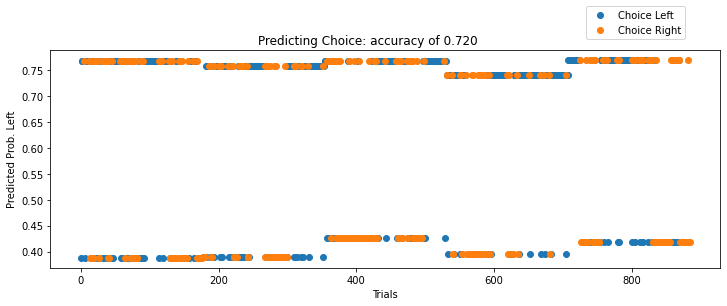

In [ ]:
classifier2 = LogisticRegression(C=0.23357214690901212, solver='liblinear')
acc5, pred5, prob5 = decode.classify(lagged_choice,
                                  choice_side, 
                                  classifier2,
                                  cross_validation=cross_validation)


plt.figure(figsize=(12,4))
plt.title(f'Predicting Choice: accuracy of {acc5:.3f}         ')
trialnumber = np.arange(len(contrast_all))
plt.plot(trialnumber[choice_side==1], prob5[choice_side==1], 'o')
plt.plot(trialnumber[choice_side==0], prob5[choice_side==0], 'o')
plt.legend(['Choice Left', 'Choice Right'], loc=(0.8,1.05))
plt.ylabel('Predicted Prob. Left')
plt.xlabel('Trials')
plt.show()

This regression, predicting the mouse’s decision using the previous decision has an accuracy of 72.0%, above the chance level. Again, this acts as a positive control as we expect mice to be influenced by their previous decisions. 


GridSearch for Previous Stimulus Model

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(lagged_choice,
                                  choice_side,  test_size= 0.8, random_state=None)

param_grid2 = {
     'penalty' : ['l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear','newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}


clfGS =  GridSearchCV(LogisticRegression(), param_grid=param_grid2, cv=3, verbose=2, n_jobs=-1)
clfGS.fit(x_train, y_train)
print("\n The best estimator across ALL searched params:\n",clfGS.best_estimator_)

Fitting 3 folds for each of 120 candidates, totalling 360 fits

 The best estimator across ALL searched params:
 LogisticRegression(C=0.615848211066026, solver='liblinear')


We used GridSearch to find the best hyperparameters for the this regressions data, although there are several sets of optimal hyperparameters they all lead to the same outcome, regarding accuracy.

### Threshold Check: Using previous trial stimulus

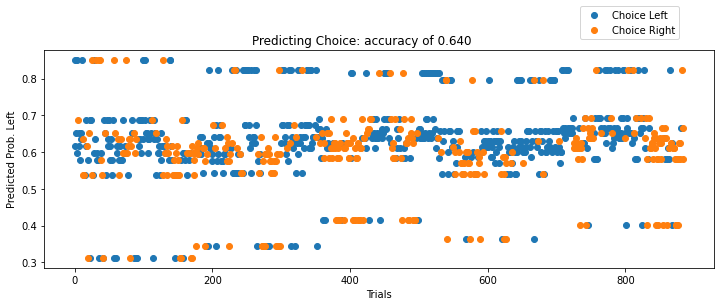

In [ ]:
classifier_prev_stim = LogisticRegression(C=0.615848211066026, solver='liblinear')
acc_stim, pred_stim, prob_stim = decode.classify(lagged_contrast,
                                  choice_side, 
                                  classifier_prev_stim,
                                  cross_validation=cross_validation)


plt.figure(figsize=(12,4))
plt.title(f'Predicting Choice: accuracy of {acc_stim:.3f}         ')
trialnumber = np.arange(len(contrast_all))
plt.plot(trialnumber[choice_side==1], prob_stim[choice_side==1], 'o')
plt.plot(trialnumber[choice_side==0], prob_stim[choice_side==0], 'o')
plt.legend(['Choice Left', 'Choice Right'], loc=(0.8,1.05))
plt.ylabel('Predicted Prob. Left')
plt.xlabel('Trials')
plt.show()

GridSearch for Previous Stimulus Model

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(lagged_contrast,
                                  choice_side,  test_size= 0.8, random_state=None)

param_grid3 = {
     'penalty' : ['l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear','newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}


clfGS =  GridSearchCV(LogisticRegression(), param_grid=param_grid3, cv=3, verbose=2, n_jobs=-1)
clfGS.fit(x_train, y_train)
print("\n The best estimator across ALL searched params:\n",clfGS.best_estimator_)

Fitting 3 folds for each of 120 candidates, totalling 360 fits

 The best estimator across ALL searched params:
 LogisticRegression(C=0.615848211066026, solver='liblinear')


We used GridSearch to find the best hyperparameters for the this regressions data, although there are several sets of optimal hyperparameters they all lead to the similar outcomes, regarding accuracy.

##Other Checks

### 50-50 Block

To address concerns related to the changing of the left-right probability blocks throughout sessions, we ran regressions with only the 50-50 block.

0.24745762711864408


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

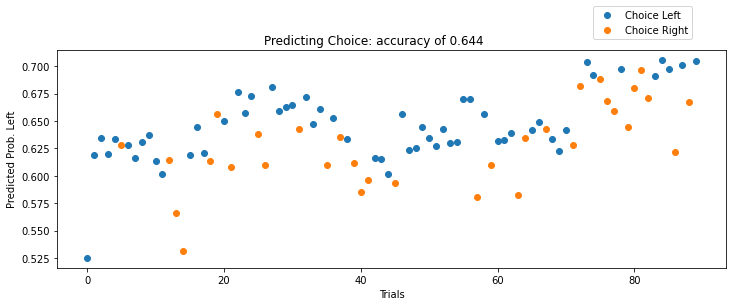

In [ ]:
block_arr = trials['probabilityLeft']
block =0.5
spike_block = spike.T[block_arr==block]
lag_choice_block = lagged_choice[block_arr==block]
contrast_block = lagged_choice[block_arr == block]
choice_block= choice_side[block_arr ==block]
print(np.mean(trials['choice']))

all_reg_block = np.hstack((spike_block, lag_choice_block, contrast_block))

acc9, pred9, prob9 = decode.classify(spike_block,
                                  choice_block.reshape(-1,1), 
                                  classifier,
                                  cross_validation=cross_validation)


plt.figure(figsize=(12,4))
plt.title(f'Predicting Choice: accuracy of {acc9:.3f}         ')
trialnumber = np.arange(len(choice_block))
plt.plot(trialnumber[choice_block==1], prob9[choice_block==1], 'o')
plt.plot(trialnumber[choice_block==0], prob9[choice_block==0], 'o')
plt.legend(['Choice Left', 'Choice Right'], loc=(0.8,1.05))
plt.ylabel('Predicted Prob. Left')
plt.xlabel('Trials')
plt.show()

In [ ]:
np.mean(choice_block)

0.6444444444444445

For the this the (first) session the 50-50 block is only present at the start meaning there is no noise due to changing blocks.
In the 50-50 model, we find 64.4% accuracy, which is as good than the chance level in this block; for whatever reason, the mouse is biased to the left, choosing left 64.4% of the time. This indicates that even without the noise from switching blocks, the pre-stimulus spiking data is insignificant. However, due to the small sample size, we are unsure as to whether we can trust this result.


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

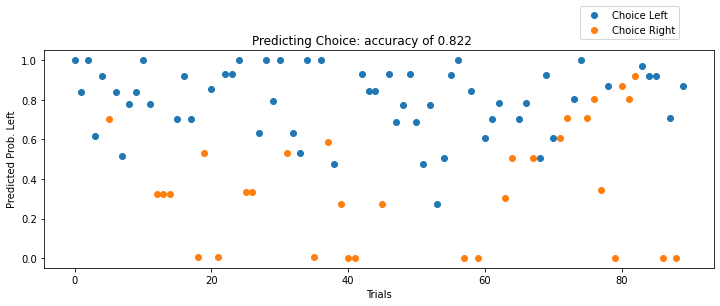

In [ ]:
block_arr = trials['probabilityLeft']
contrast_block = contrast_all[block_arr == block].reshape(-1,1)
choice_block= choice_side[block_arr ==block]

no_spike_block= np.hstack((contrast_block))
lag_choice_block = lagged_choice[block_arr==block]

acc8, pred8, prob8 = decode.classify(contrast_block,
                                  choice_block.reshape(-1,1), 
                                  classifier_contrast,
                                  cross_validation=cross_validation)


plt.figure(figsize=(12,4))
plt.title(f'Predicting Choice: accuracy of {acc8:.3f}         ')
trialnumber = np.arange(len(choice_block))
plt.plot(trialnumber[choice_block==1], prob8[choice_block==1], 'o')
plt.plot(trialnumber[choice_block==0], prob8[choice_block==0], 'o')
plt.legend(['Choice Left', 'Choice Right'], loc=(0.8,1.05))
plt.ylabel('Predicted Prob. Left')
plt.xlabel('Trials')
plt.show()

The contrast model performs far better than the spiking model for the 50-50 block. This is to be expected, as seen in the other regressions. The model here performs slightly worse than for the entire session (by about 2%), and this might be suggestive of the fact that the mouse presents a leftward bias even in 50-50 blocks. This is highly conjectural, but perhaps the mouse does not rely on the stimulus as much in these trials given its leftward bias.

###Another inquiry: Predicting Previous Choice

Regress the spiking data against the previous choice to test for residual activity

In [ ]:
from scipy.linalg import toeplitz #function for making a time-lag design matrix


def make_design(source,d): #create a function that takes a matrix and outputs design matrix
  if source.ndim == 1: 
    source = np.expand_dims(source,1)
  source_toep = np.zeros((source.shape[0], d*source.shape[1])) 
  for i in range(source.shape[1]): 
    source_toep[1:,d* i: d* (i+1)] = toeplitz(source[:-1,i], np.zeros(d))  
  
  return source_toep

lagged_choice = make_design(choice_side, d=1)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

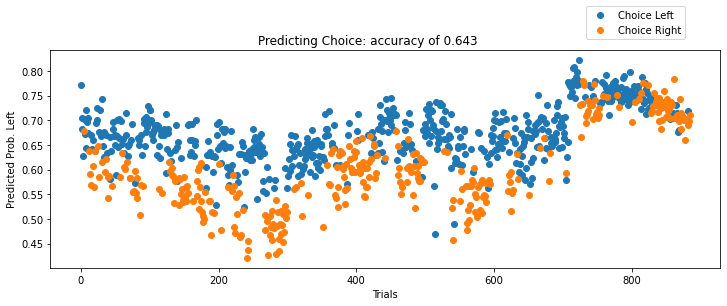

In [ ]:
acc_stim, pred_stim, prob_stim = decode.classify(spike.T,
                                  lagged_choice, 
                                  classifier,
                                  cross_validation=cross_validation)


plt.figure(figsize=(12,4))
plt.title(f'Predicting Choice: accuracy of {acc_stim:.3f}         ')
trialnumber = np.arange(len(contrast_all))
plt.plot(trialnumber[choice_side==1], prob_stim[choice_side==1], 'o')
plt.plot(trialnumber[choice_side==0], prob_stim[choice_side==0], 'o')
plt.legend(['Choice Left', 'Choice Right'], loc=(0.8,1.05))
plt.ylabel('Predicted Prob. Left')
plt.xlabel('Trials')
plt.show()

With an accuracy of 64.3% the model shows that pre-stimulus spiking data is only slightly predictive of the mouse’s decision in the previous trial. This is an interesting finding, as we may expect the previous trial to have a significant impact on pre-stimulus spiking for the next trial.


## Scanning across sessions

Define a function to regress pre-stimulus (our model) and post-stimulus (a positive control) for a given session

In [ ]:
def regress_session(sesh):
  # Load in the neural data of the first insertion
  sl = SpikeSortingLoader(pid=pids[int(sesh)], one=one, atlas=ba)
  spikes, clusters, channels = sl.load_spike_sorting()
  clusters = sl.merge_clusters(spikes, clusters, channels)

  # Load in trials
  trials = one.load_object(one.pid2eid(pids[int(sesh)])[0], 'trials')
  #Load spikes for BEFORE stimulus
  intervals_previous = np.vstack((trials['stimOn_times']-0.05, trials['stimOn_times']-0.005)).T
  spike, _ = decode.get_spike_counts_in_bins(spikes['times'], spikes['clusters'], intervals=intervals_previous)
  spike=stats.zscore(spike, axis = 1)
  spike= np.nan_to_num(spike,copy=False)
  #Load choice
  choice_side = np.asarray((trials['choice']+1)/2,dtype=int)
  #Establish threshold
  threshold = np.mean(choice_side)
  if threshold < 0.5:
    threshold = 1-threshold
  #Regress
  cross_validation = KFold(n_splits=5)
  classifier = LogisticRegression(max_iter=1e4, C=0.001)
  acc_pre, pred_pre, prob_pre = decode.classify(spike.T,
                                  choice_side, 
                                  classifier,
                                  cross_validation=cross_validation)
  
  #Load spikes for after stimulus
  intervals_previous = np.vstack((trials['stimOn_times'], trials['stimOn_times']+ 0.4)).T
  spike, _ = decode.get_spike_counts_in_bins(spikes['times'], spikes['clusters'], intervals=intervals_previous)
  spike=stats.zscore(spike, axis = 1)
  spike= np.nan_to_num(spike,copy=False)
  #Regress
  cross_validation = KFold(n_splits=5)
  classifier = LogisticRegression(max_iter=1e4, C=0.001)
  acc_post, pred_post, prob_post = decode.classify(spike.T,
                                  choice_side, 
                                  classifier,
                                  cross_validation=cross_validation)
  if acc_pre > threshold:
    print("significance at session", sesh,"!!!","margin:", acc_pre - threshold,"acc:", acc_pre)
  return(acc_pre, acc_post)


Regress several sessions and compare

In [ ]:
session_inds = np.linspace(0,540,55)
print(session_inds)
pp_accs = np.zeros((len(session_inds),2))
for i in range(len(session_inds)):
  regression = regress_session(session_inds[i])
  pp_accs[int(i),0]= regression[0]
  pp_accs[int(i),1]=regression[1]


[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250. 260. 270.
 280. 290. 300. 310. 320. 330. 340. 350. 360. 370. 380. 390. 400. 410.
 420. 430. 440. 450. 460. 470. 480. 490. 500. 510. 520. 530. 540.]


/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS091/2022-07-04/001/alf/probe01/pykilosort/spikes.amps.npy: 100%|██████████| 49.2M/49.2M [00:01<00:00, 41.6MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS091/2022-07-04/001/alf/probe01/pykilosort/spikes.clusters.npy: 100%|██████████| 24.6M/24.6M [00:00<00:00, 33.3MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS091/2022-07-04/001/alf/probe01/pykilosort/spikes.depths.npy: 100%|██████████| 49.2M/49.2M [00:00<00:00, 76.8MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS091/2022-07-04/001/alf/probe01/pykilosort/spikes.times.npy: 100%|██████████| 49.2M/49.2M [00:00<00:00, 79.8MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS091/2022-07-04/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.8kB/s]
/root/Downloads/ONE/openalyx.i

significance at session 50.0 !!! margin: 0.12834224598930488 acc: 0.643048128342246


/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA033/2022-02-15/001/alf/probe01/pykilosort/spikes.amps.npy: 100%|██████████| 131M/131M [00:01<00:00, 81.2MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA033/2022-02-15/001/alf/probe01/pykilosort/spikes.clusters.npy: 100%|██████████| 65.4M/65.4M [00:00<00:00, 107MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA033/2022-02-15/001/alf/probe01/pykilosort/spikes.depths.npy: 100%|██████████| 131M/131M [00:01<00:00, 120MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA033/2022-02-15/001/alf/probe01/pykilosort/spikes.times.npy: 100%|██████████| 131M/131M [00:01<00:00, 114MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab_ucla/Subjects/UCLA033/2022-02-15/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<0

significance at session 150.0 !!! margin: 0.02304147465437789 acc: 0.5737327188940092


/root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-31/001/alf/probe00/pykilosort/spikes.amps.npy: 100%|██████████| 104M/104M [00:03<00:00, 31.2MB/s] 
/root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-31/001/alf/probe00/pykilosort/spikes.clusters.npy: 100%|██████████| 52.0M/52.0M [00:01<00:00, 47.9MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-31/001/alf/probe00/pykilosort/spikes.depths.npy: 100%|██████████| 104M/104M [00:01<00:00, 85.1MB/s] 
/root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-31/001/alf/probe00/pykilosort/spikes.times.npy: 100%|██████████| 104M/104M [00:01<00:00, 94.8MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/wittenlab/Subjects/ibl_witten_26/2021-01-31/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 14.6

significance at session 200.0 !!! margin: 0.05597964376590325 acc: 0.5877862595419847


/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-12-05/001/alf/probe01/pykilosort/spikes.amps.npy: 100%|██████████| 69.1M/69.1M [00:01<00:00, 60.6MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-12-05/001/alf/probe01/pykilosort/spikes.clusters.npy: 100%|██████████| 34.5M/34.5M [00:00<00:00, 60.8MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-12-05/001/alf/probe01/pykilosort/spikes.depths.npy: 100%|██████████| 69.1M/69.1M [00:00<00:00, 111MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-12-05/001/alf/probe01/pykilosort/spikes.times.npy: 100%|██████████| 69.1M/69.1M [00:00<00:00, 108MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/cortexlab/Subjects/KS046/2020-12-05/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.5kB/s]
/root/Downloads/ONE/openalyx.int

significance at session 210.0 !!! margin: 0.0015243902439024959 acc: 0.6600609756097561


/root/Downloads/ONE/openalyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-30/001/alf/probe01/pykilosort/spikes.amps.npy: 100%|██████████| 25.6M/25.6M [00:01<00:00, 23.6MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-30/001/alf/probe01/pykilosort/spikes.clusters.npy: 100%|██████████| 12.8M/12.8M [00:00<00:00, 23.6MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-30/001/alf/probe01/pykilosort/spikes.depths.npy: 100%|██████████| 25.6M/25.6M [00:00<00:00, 55.1MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-30/001/alf/probe01/pykilosort/spikes.times.npy: 100%|██████████| 25.6M/25.6M [00:00<00:00, 52.7MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/hoferlab/Subjects/SWC_061/2020-11-30/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.7kB/s]
/root/Downloads/ONE/opena

significance at session 250.0 !!! margin: 0.00911854103343468 acc: 0.5881458966565349


/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-20/001/alf/probe00/pykilosort/spikes.amps.npy: 100%|██████████| 30.5M/30.5M [00:01<00:00, 28.3MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-20/001/alf/probe00/pykilosort/spikes.clusters.npy: 100%|██████████| 15.2M/15.2M [00:00<00:00, 31.3MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-20/001/alf/probe00/pykilosort/spikes.depths.npy: 100%|██████████| 30.5M/30.5M [00:00<00:00, 59.3MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-20/001/alf/probe00/pykilosort/spikes.times.npy: 100%|██████████| 30.5M/30.5M [00:00<00:00, 59.4MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_018/2020-10-20/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.6kB/s]
/root/Downloads/ONE/openalyx.internation

significance at session 280.0 !!! margin: 0.021015761821365997 acc: 0.5586690017513135


/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_020/2020-10-01/001/alf/probe01/pykilosort/spikes.amps.npy: 100%|██████████| 109M/109M [00:01<00:00, 70.3MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_020/2020-10-01/001/alf/probe01/pykilosort/spikes.clusters.npy: 100%|██████████| 54.7M/54.7M [00:00<00:00, 88.5MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_020/2020-10-01/001/alf/probe01/pykilosort/spikes.depths.npy: 100%|██████████| 109M/109M [00:01<00:00, 97.8MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_020/2020-10-01/001/alf/probe01/pykilosort/spikes.times.npy: 100%|██████████| 109M/109M [00:01<00:00, 95.8MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_020/2020-10-01/001/alf/probe01/pykilosort/channels.localCoordinates.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 19.4kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/

significance at session 300.0 !!! margin: 0.0173124484748558 acc: 0.5309150865622424


/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_016/2020-09-15/001/alf/probe01/pykilosort/spikes.amps.npy: 100%|██████████| 141M/141M [00:01<00:00, 87.1MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_016/2020-09-15/001/alf/probe01/pykilosort/spikes.clusters.npy: 100%|██████████| 70.3M/70.3M [00:02<00:00, 35.1MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_016/2020-09-15/001/alf/probe01/pykilosort/spikes.depths.npy: 100%|██████████| 141M/141M [00:01<00:00, 118MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_016/2020-09-15/001/alf/probe01/pykilosort/spikes.times.npy: 100%|██████████| 141M/141M [00:01<00:00, 84.5MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_016/2020-09-15/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.7kB/s]
/root/Downloads/ONE/openalyx.internationalbrain

significance at session 340.0 !!! margin: 0.006172839506172756 acc: 0.5792181069958847


/root/Downloads/ONE/openalyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_026/2020-08-14/002/alf/probe01/pykilosort/spikes.amps.npy: 100%|██████████| 109M/109M [00:02<00:00, 52.4MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_026/2020-08-14/002/alf/probe01/pykilosort/spikes.clusters.npy: 100%|██████████| 54.6M/54.6M [00:01<00:00, 50.8MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_026/2020-08-14/002/alf/probe01/pykilosort/spikes.depths.npy: 100%|██████████| 109M/109M [00:01<00:00, 89.8MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_026/2020-08-14/002/alf/probe01/pykilosort/spikes.times.npy: 100%|██████████| 109M/109M [00:01<00:00, 88.3MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/zadorlab/Subjects/CSH_ZAD_026/2020-08-14/002/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 11.8kB/s]
/root/Downl

significance at session 350.0 !!! margin: 0.003603603603603567 acc: 0.654054054054054


/root/Downloads/ONE/openalyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_038/2020-07-31/001/alf/probe00/pykilosort/spikes.amps.npy: 100%|██████████| 58.7M/58.7M [00:03<00:00, 17.9MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_038/2020-07-31/001/alf/probe00/pykilosort/spikes.clusters.npy: 100%|██████████| 29.4M/29.4M [00:01<00:00, 27.4MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_038/2020-07-31/001/alf/probe00/pykilosort/spikes.depths.npy: 100%|██████████| 58.7M/58.7M [00:00<00:00, 65.5MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_038/2020-07-31/001/alf/probe00/pykilosort/spikes.times.npy: 100%|██████████| 58.7M/58.7M [00:00<00:00, 89.7MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_038/2020-07-31/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.5k

significance at session 370.0 !!! margin: 0.0015723270440252124 acc: 0.6965408805031447


/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_014/2020-07-18/001/alf/probe01/pykilosort/spikes.amps.npy: 100%|██████████| 50.9M/50.9M [00:01<00:00, 45.9MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_014/2020-07-18/001/alf/probe01/pykilosort/spikes.clusters.npy: 100%|██████████| 25.5M/25.5M [00:00<00:00, 44.7MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_014/2020-07-18/001/alf/probe01/pykilosort/spikes.depths.npy: 100%|██████████| 50.9M/50.9M [00:00<00:00, 83.5MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_014/2020-07-18/001/alf/probe01/pykilosort/spikes.times.npy: 100%|██████████| 50.9M/50.9M [00:00<00:00, 93.9MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_014/2020-07-18/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 16.0kB/s]
/root/Downloads/ONE/openalyx.internation

significance at session 380.0 !!! margin: 0.0018083182640143969 acc: 0.5189873417721519


/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_014/2020-07-14/001/alf/probe01/pykilosort/spikes.amps.npy: 100%|██████████| 54.6M/54.6M [00:01<00:00, 47.1MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_014/2020-07-14/001/alf/probe01/pykilosort/spikes.clusters.npy: 100%|██████████| 27.3M/27.3M [00:00<00:00, 55.2MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_014/2020-07-14/001/alf/probe01/pykilosort/spikes.depths.npy: 100%|██████████| 54.6M/54.6M [00:00<00:00, 73.3MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_014/2020-07-14/001/alf/probe01/pykilosort/spikes.times.npy: 100%|██████████| 54.6M/54.6M [00:00<00:00, 90.7MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_014/2020-07-14/001/alf/probe01/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.4kB/s]
/root/Downloads/ONE/openalyx.internation

significance at session 410.0 !!! margin: 0.010526315789473717 acc: 0.5877192982456141


/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-15/001/alf/probe00/pykilosort/spikes.amps.npy: 100%|██████████| 54.9M/54.9M [00:01<00:00, 50.4MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-15/001/alf/probe00/pykilosort/spikes.clusters.npy: 100%|██████████| 27.4M/27.4M [00:00<00:00, 45.7MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-15/001/alf/probe00/pykilosort/spikes.depths.npy: 100%|██████████| 54.9M/54.9M [00:00<00:00, 81.0MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-15/001/alf/probe00/pykilosort/spikes.times.npy: 100%|██████████| 54.9M/54.9M [00:00<00:00, 86.7MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-15/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 18.4kB/s]


significance at session 420.0 !!! margin: 0.0016835016835017313 acc: 0.6767676767676768


/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/probe00/pykilosort/spikes.amps.npy: 100%|██████████| 86.9M/86.9M [00:01<00:00, 70.6MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/probe00/pykilosort/spikes.clusters.npy: 100%|██████████| 43.4M/43.4M [00:00<00:00, 66.9MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/probe00/pykilosort/spikes.depths.npy: 100%|██████████| 86.9M/86.9M [00:00<00:00, 96.0MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/probe00/pykilosort/spikes.times.npy: 100%|██████████| 86.9M/86.9M [00:00<00:00, 100MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL060/2020-03-09/002/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.8kB/s]
/

significance at session 440.0 !!! margin: 0.018789144050104345 acc: 0.5866388308977035


/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_009/2020-03-02/001/alf/probe00/pykilosort/spikes.amps.npy: 100%|██████████| 31.4M/31.4M [00:01<00:00, 28.4MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_009/2020-03-02/001/alf/probe00/pykilosort/spikes.clusters.npy: 100%|██████████| 15.7M/15.7M [00:00<00:00, 36.9MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_009/2020-03-02/001/alf/probe00/pykilosort/spikes.depths.npy: 100%|██████████| 31.4M/31.4M [00:00<00:00, 61.5MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_009/2020-03-02/001/alf/probe00/pykilosort/spikes.times.npy: 100%|██████████| 31.4M/31.4M [00:00<00:00, 54.8MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/danlab/Subjects/DY_009/2020-03-02/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.3kB/s]
/root/Downloads/ONE/openalyx.internation

significance at session 490.0 !!! margin: 0.026859504132231482 acc: 0.5392561983471075


/root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-12/2020-01-22/001/alf/probe00/pykilosort/spikes.amps.npy: 100%|██████████| 53.1M/53.1M [00:01<00:00, 44.0MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-12/2020-01-22/001/alf/probe00/pykilosort/spikes.clusters.npy: 100%|██████████| 26.6M/26.6M [00:00<00:00, 53.4MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-12/2020-01-22/001/alf/probe00/pykilosort/spikes.depths.npy: 100%|██████████| 53.1M/53.1M [00:00<00:00, 90.8MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-12/2020-01-22/001/alf/probe00/pykilosort/spikes.times.npy: 100%|██████████| 53.1M/53.1M [00:00<00:00, 92.1MB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-12/2020-01-22/001/alf/probe00/pykilosort/channels.brainLocationIds_ccf_2017.npy: 100%|██████████| 3.20k/3.20k [00:00<00:00, 17.0kB/s]
/root/Downloads

We ran the main model, looking at the impact predictive power of pre-stimulus spiking on a mouse chose left, on 54 other sessions to make sure that our conclusions are valid for other sessions as well. We find that the results hold for all but one session. For those sessions there was either no difference or no significant difference between the null model and the accuracy of the main model. Thus, this provides robustness to our findings. 

The one model that had a significant difference, the neuron's weights were small enough and similar enough that it did not seem likely to inform us further.

Additionally, the bar chart below clearly shows that, as expected, the post-stimlus data is a far better predictor than pre-stimulus spiking. Again, this helps validate our framework.

Average accuracy versus control accuracy over time

In [ ]:
mean_pre_post=[np.mean(pp_accs[:,0]),np.mean(pp_accs[:,1])]
std = np.std(mean_pre_post)
plt.bar([0,1], mean_pre_post, yerr = std)
plt.xlabel("pre vs. post stimulus data")
plt.ylabel("scores on regression with standard deviation")


NameError: ignored

# Bibliography

1) Sashank Pisupati, Lital Chartarifsky-Lynn, Anup Khanal, Anne K Churchland (2021) Lapses in perceptual decisions reflect exploration eLife 10:e55490
https://doi.org/10.7554/eLife.55490

The paper examines constant errors that exist in decision making independent of evidence
strength, using rats. The authors define these errors as “lapses,” looking at these as nuisances “arising from noise tangential to the decision.” This is relevant to our question because they explore why errors occur regardless of evidence strength. They propose that “lapses reflect a strategic trade-off between exploiting known rewarding actions and exploring uncertain ones.”

2) Steinmetz, N.A., Zatka-Haas, P., Carandini, M. et al. Distributed coding of choice, action and engagement across the mouse brain. Nature 576, 266–273 (2019). https://doi.org/10.1038/s41586-019-1787-x

This paper discusses a very similar neuropixel dataset collected from mice and analyzed against each animal’s choice of left or right. It contains a lot of informative general findings about firing rates in different states (across different times, during  different states, etc.) which helps guide us towards which regions may be implicated in our hypothesis.

3) https://stats.stackexchange.com/questions/27730/choice-of-k-in-k-fold-cross-validation

This forum discussion highlights the costs and benefits with choosing more folds in cross validation, which guided our hyperparameter choice.

